**Class 2: Online Value Function Prediction.**

1. [Everything you need to know](#everything)
2. [Value prediction](#pred)
    1. [Model-based value prediction](#model)
    1. [Monte-Carlo evaluation](#mc)
    3. [Temporal differences learning](#td0)
    4. [TD($\lambda$)](#tdlambda)
    5. [Summary](#predsummary)
3. [Value function approximation](#approx)
    1. [Linear value function approximation](#linear)
    2. [The tabular case is just a specific case of linear model](#tab)
    3. [TD($\lambda$) as a parametric model update](#param)
    4. [Non-parametric models](#nonparam)

# <a id="everything"></a>Everything you need to know


Everything you should remember after this session.<br>
<br>
<div class="alert alert-success">
<ul>
<li> Model-based RL: infer an MDP model from samples, solve the evaluation equation for this model.
<li> Online, stochastic approximation of $V^\pi$:
$$V(s_t) \leftarrow V(s_t) + \alpha \left[ R - V(s_t) \right]$$
where $R$ is the <i>target</i> sample of $V^\pi$.<br>
This procedures converges to $V^\pi$ under the Robbins-Monro conditions: $\sum\limits_{t=0}^\infty \alpha_t = \infty$ and  $\sum\limits_{t=0}^\infty \alpha_t^2 < \infty$.
<li> Online Monte-Carlo estimates: given a finite length episode, target $R=R_t = \sum_{i<t} \gamma^{i-t} r_i$.
<li> Given a sample $(s,a=\pi(s),r,s')$, the temporal difference is $\delta=r + \gamma V(s') - V(s)$.
<li> TD(0) update: given a sample $(s,a=\pi(s),r,s')$, target $R=R_t^{(1)}=r + \gamma V(s')$.
<li> TD(0) update on $Q$-functions: given a sample $(s,a,r,s')$, the temporal difference is $\delta = r + \gamma Q(s',\pi(s') - Q(s,a)$ and the update of $Q$ is $Q(s,a) \leftarrow Q(s,a) + \alpha \delta$. This update is off-policy.
<li> $n$-step return: $R=R^{(n)}_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \ldots + \gamma^n V_t(s_{t+n})$.
<li> $\lambda$-return: $R=R^\lambda_t = \left(1-\lambda\right) \sum\limits_{n=1}^\infty \lambda^{n-1}R_t^{(n)}$.
<li> TD($\lambda$) algorithm: Given a new sample $(s_t,a_t=\pi(s_t),r_t,s_t')$.
<ol>
<li> Temporal difference $\delta = r_t+\gamma V(s_t') - V(s_t)$.
<li> Update eligibility traces for all states<br>
$e(s) \leftarrow \left\{\begin{array}{ll}
\gamma \lambda e(s) & \textrm{if } s\neq s_t\\
1\textrm{ (or }1+e(s)\textrm{)} & \textrm{if } s=s_t
\end{array}\right.$
<li> Update all state's values $V(s) \leftarrow V(s) + \alpha e(s) \delta$
</ol>
<li> TD($\lambda$) implements the $\lambda$-return algorithm.
<li> TD($\lambda$) (accumulating traces) with parametric function approximation. With $V(s) = V_\theta(s), \theta \in \mathbb{R}^K$, $e \in \mathbb{R}^K$. Initially, $e=0$. Given a new sample $(s_t,a_t=\pi(s_t),r_t,s_t')$.
<ol>
<li> Temporal difference $\delta = r_t+\gamma V_\theta(s_t') - \theta^T V_\theta(s_t)$.
<li> Update eligibility traces for all states $e \leftarrow \nabla_\theta V_\theta(s) + \gamma \lambda e$
<li> Update value function $\theta \leftarrow \theta + \alpha e \delta$
</ol>
</ul>
</div>

Of course, all this seems very obscure right now and the block above will only serve as a reminder when you re-open the notebook later. We will introduce every concept intuitively and progessively.

# <a id="pred"></a>Value prediction

Back on the frozen lake example from the previous class.

In [2]:
import gym
import gym.envs.toy_text.frozen_lake as fl
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
np.set_printoptions(precision=3)

In [3]:
env = gym.make('FrozenLake-v0')
env.render()

actions = {fl.LEFT: '\u2190', fl.DOWN: '\u2193', fl.RIGHT: '\u2192', fl.UP: '\u2191'}
print(actions)

def to_s(row,col):
    return row*env.unwrapped.ncol+col

def to_row_col(s):
    col = s%env.unwrapped.ncol
    row = int((s-col)/env.unwrapped.ncol)
    return row,col


SFFF
FHFH
FFFH
HFFG
{0: '←', 1: '↓', 2: '→', 3: '↑'}


Take a fixed policy $\pi$. What is its expected value from the starting state (or any other state)?

In this section, we will develop 5 different (but related) approches to this question:
1. Get samples $(s,\pi(s),r,s')$, estimate $p^\pi$ and $r^\pi$, then solve $V=T^\pi V$<br>
$\rightarrow$ model-based prediction
2. Run successive trials and update $V^\pi(s)$ in all encountered $s$<br>
$\rightarrow$ Offline Monte Carlo
3. Run one trial and update all visited $s$ by back-propagation<br>
$\rightarrow$ Online Monte Carlo
4. Get one sample $(s,\pi(s),r,s')$ and update $V^\pi(s)$ given $r$ and $V^\pi(s')$<br>
$\rightarrow$ TD(0)
5. Get one sample $(s,\pi(s),r,s')$ and update $V^\pi(s)$ in all states<br>
$\rightarrow$ TD($\lambda$)

## <a id="model"></a>Model-based Value Prediction

If we can interact with the simulator, we can collect samples and approximate the transition and reward models, then use them to perform model-based resolution of the evaluation equation (as in the previous class).

<div class="alert alert-warning"><b>Exercice:</b><br>
Let's implement this for the policy that always goes right. Run 10000 episodes until termination (or until a maximum limit of 1000 time steps) and reconstruct an approximation of the transition kernel and reward vector for this policy. Use them to solve the evaluation equation.
</div>
Watch out for states from which no transition starts (either because they are terminal states or because they were not reached by this policy): the transition matrix needs to remain valid for the corresponding lines.

In [4]:
# parameters
gamma = 0.9
epsilon = 1e-4
max_steps = 1000
max_episodes = 10000
max_iter_VI = 100
P_pi = np.zeros((env.observation_space.n, env.observation_space.n))
r_pi = np.zeros((env.observation_space.n))
x_count = np.zeros((env.observation_space.n))

# collect samples, count transitions and accumulate rewards
total_steps = 0
for ep in range(max_episodes):
    x = env.reset()
    for t in range(max_steps):
        y,r,d,_ = env.step(fl.RIGHT)
        P_pi[x][y] += 1
        r_pi[x] += r
        x_count[x] += 1
        if d==True:
            break
        else:
            x=y

# normalize
for x in range(env.observation_space.n):
    if x_count[x]==0: # unreached states
        P_pi[x][x] = 1
        r_pi[x] = 0
    else:
        P_pi[x][:] = P_pi[x][:]/x_count[x]
        r_pi[x]    = r_pi[x]   /x_count[x]


# compute V with value iteration
V = np.zeros((env.observation_space.n))
W = np.zeros((env.observation_space.n))
residuals = np.zeros((max_iter_VI))
for i in range(max_iter_VI):
    W = r_pi + gamma * np.dot(P_pi, V)
    residuals[i] = np.max(np.abs(W-V))
    V = W
    if residuals[i]<epsilon:
        residuals = residuals[:i+1]
        break

print(V)

[0.013 0.012 0.027 0.    0.018 0.    0.063 0.    0.049 0.144 0.182 0.
 0.    0.308 0.564 0.   ]


Let's compare with the true values.

In [5]:
r_pi = np.zeros((env.observation_space.n))
P_pi = np.zeros((env.observation_space.n, env.observation_space.n))
for x in range(env.observation_space.n):
    outcomes = env.unwrapped.P[x][fl.RIGHT]
    for o in outcomes:
        p = o[0]
        y = o[1]
        r = o[2]
        P_pi[x,y] += p
        r_pi[x] += r*p

# compute V with value iteration
Vtrue = np.zeros((env.observation_space.n))
W = np.zeros((env.observation_space.n))
residuals = np.zeros((max_iter_VI))
for i in range(max_iter_VI):
    W = r_pi + gamma * np.dot(P_pi, Vtrue)
    residuals[i] = np.max(np.abs(W-V))
    Vtrue = W
    if residuals[i]<epsilon:
        residuals = residuals[:i+1]
        break

print(Vtrue)

[0.013 0.012 0.027 0.    0.019 0.    0.064 0.    0.049 0.146 0.186 0.
 0.    0.301 0.556 0.   ]


So we can see this is a fall-back solution that happens to work reasonably well. This approach is generally called **model-based prediction** or **adaptive dynamic programming** or **indirect reinforcement learning**. It converges to the true $p(s'|s,\pi(s))$, $r(s,\pi(s)$ and $V^\pi$ if the samples are identically and independently distributed (iid). It has the advantage of working both **online** and **offline**. It is however **on-policy**, that is one cannot use samples collected from the execution of $\pi$ to evaluate $\pi'$.

But in the end there is no direct evaluation of the policy's value, and our intuition tells us that a player is generally able to tell what a policy is worth in a certain state, even though he has never explicitly estimated the transition and reward models. So we must be able to design model-free evaluation methods.

## <a id="mc"></a>Monte-Carlo evaluation

Monte Carlo methods are intuitive, episode-based methods. 

Let us start with a fully **offline Monte-Carlo**. The idea is simple: start from $s$, run the policy until termination (or for a long number of steps), repeat for a number of episodes, then update the value of all encountered states. This requires to store in memory full episodes (it also requires that the episodes be finite-length).

Let us move directly to an **online Monte-Carlo** method. It is almost the same idea: start from $s$, run the policy until termination (or for a long number of steps) then update the value of all encountered states before restarting an episode. 

Let $(s_0, r_0, s_1, \ldots, s_T)$ be the sequence of transitions of such an episode. Then, this procedure provides an estimate $R_t$ of the value of the state $s_t$ encountered at time step $t$:
<div class="alert alert-success"><b>Monte Carlo return:</b>
$$R_t = \sum_{i>t} \gamma^{i-t} r_i$$
</div>

Let $R^\pi(s)$ be the random variable corresponding to the sum of discounted rewards one can obtain from $s$. Then $V^\pi(s) = \mathbb{E}(R^\pi(s))$. Since $R(s_t)$ is a realization of $R(s)$, one can design a **stochastic approximation** procedure that converges to $V^\pi(s_t)$:
<div class="alert alert-success"><b>Stochastic approximation of $V^\pi$:</b>
$$V(s_t) \leftarrow V(s_t) + \alpha \left[ R_t - V(s_t) \right]$$
</div>

For those unfamiliar with stochastic approximation procedures, we can understand the previous update as: $R_t$ are samples estimates of $V^\pi(s_t)$. If I already have an estimation of $V(s_t)$ of $V^\pi(s_t)$ and I receive a new sample $R_t$, I should "pull" my previous estimate towards $R_t$, but $R_t$ carries a part of noise, so I should be cautious and only take a small step $\alpha$ in the direction of $R_t$. This type of stochastic approximation procedure converges if it respects Robbins-Monro's conditions:
<div class="alert alert-success"><b>Robbins-Monro convergence conditions:</b>
$$\sum\limits_{t=0}^\infty \alpha_t = \infty \quad \textrm{  and  } \quad \sum\limits_{t=0}^\infty \alpha_t^2 < \infty.$$
</div>
Intuitive explanation. These conditions simply say that any value $V^\pi(s)$ should be reachable given any initial guess $V(s)$, no matter how far from $V^\pi(s)$ is from this first guess; hence the $\sum\limits_{t=0}^\infty \alpha_t = \infty$. However, we still need the step-size to be decreasing so that we don't start oscillating around $V^\pi(s)$ when we get closer; so to insure convergence we impose $\sum\limits_{t=0}^\infty \alpha_t^2 < \infty$.

<div class="alert alert-warning"><b>Exercice:</b><br>
Implement an online Monte-Carlo estimation for $V^\pi$. We decide we can tolerate a 0.001 error on $V^\pi$ so, to keep things simple, we set $\alpha=0.001$.
</div>

[0.015 0.015 0.036 0.    0.018 0.    0.073 0.    0.05  0.144 0.182 0.
 0.    0.309 0.556 0.   ]
[0.013 0.012 0.027 0.    0.019 0.    0.064 0.    0.049 0.146 0.186 0.
 0.    0.301 0.556 0.   ]


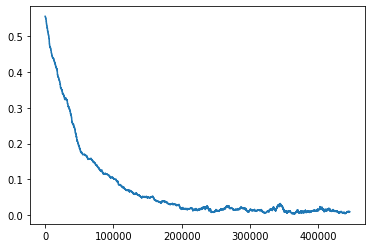

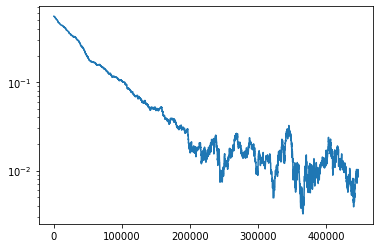

In [5]:
# parameters
gamma = 0.9
alpha = 0.001
max_steps = 1000
max_episodes = 100000
V = np.zeros((env.observation_space.n))

# error plotting
error = np.zeros((max_episodes)) # used to track the convergence to Vtrue...
cumulated_steps = np.zeros((max_episodes)) # ... against the number of samples

for ep in range(max_episodes):
    x = env.reset()
    episode = []
    # Run episode
    for t in range(max_steps):
        y,r,d,_ = env.step(fl.RIGHT)
        episode.append([x,r])
        if d==True:
            cumulated_steps[ep] = cumulated_steps[ep-1] + t
            break
        else:
            x=y
    # Update values
    T = len(episode)
    R = np.zeros((T))
    R[-1] = episode[-1][1]
    x = episode[-1][0]
    V[x] = V[x] + alpha * (R[-1] - V[x])
    for t in range(-2,-T-1,-1):
        R[t] = episode[t][1] + gamma*R[t+1]
        x = episode[t][0]
        V[x] = V[x] + alpha * (R[t] - V[x])
    error[ep] = np.max(np.abs(V-Vtrue))

print(V)
print(Vtrue)
plt.plot(cumulated_steps,error)
plt.figure()
plt.semilogy(cumulated_steps,error);

So online Monte-Carlo allows us to update $V^\pi$ episode after episode. Some values are better estimated than others depending on how often the corresponding state was visited.

Monte-Carlo estimation has some flaws nonetheless. It still requires to store one full episode in memory before $V$ is updated. Also, one rare value for $r_t$ affects directly all the value of the states encountered before $s_t$. So we can question the robustness of this estimator.

## <a id="td0"></a>Temporal Differences learning

We want to replace Monte-Carlo estimation by a step by step update that only takes $(s,r,s')$ as an input. The key remark we make is that once the $(s,r,s')$ transition is over we can update our knowledge of $V(s)$ by using $r+\gamma V(s')$. This estimate uses $V(s')$ to *bootstrap*[1] the estimator of $V(s)$.

[1] This *bootstrap* operation has nothing to do with the statistical procedure of *bootstrapping*.

To get an intuitive understanding of why we can do that, take the following example. You are driving from home to the airport. Half-way, you realize traffic is denser than you usually estimate and you're already 5 minutes behind schedule. Home is $s$, half-way is $s'$, those 5 minutes are $r$. To update your belief about the average length of the trip home$\rightarrow$airport ($V(s)$), you don't need to wait until you reach the airport (as a Monte-Carlo estimate would have required). Instead, you can update this belief using $r+V(s')$, the sum of what you observed and what you currently estimate for the rest of the trip. As long as you update all states often enough, the whole procedure should converge to the true $V$.

So here is the update that we shall call TD(0):
<div class="alert alert-success"><b>TD(0) temporal difference update:</b>
$$V(s) \leftarrow V(s) + \alpha \left[ r + \gamma V(s') - V(s) \right]$$
</div>

$\delta=r + \gamma V(s') - V(s)$ is called the prediction **temporal difference** (hence the name TD(0) for the algorithm - the "0" will be explained in the next section). It is the difference between our estimate $V(s)$ *before* obtaining the information of $r$ and the bootstrapped value $r+\gamma V(s')$.
<div class="alert alert-success"><b>Temporal difference:</b>
$$\delta=r + \gamma V(s') - V(s)$$
</div>

**Bootstrapping** (in this particular context) is the operation of using the value of $V(s')$ to update $V(s)$.

This is a sample-by-sample update (no need to remember full episodes) and, more importantly, it is adapted to non-episodic environments (with no terminal states). As for online Monte-Carlo, the update above converges to $V^\pi$ if $\alpha$ respects the Robbins-Monro conditions:
$$\sum\limits_{t=0}^\infty \alpha_t = \infty \quad \textrm{  and  } \quad \sum\limits_{t=0}^\infty \alpha_t^2 < \infty.$$

Often, TD methods converge faster and are more robust estimators than Monte Carlo ones (but not always).

<div class="alert alert-warning"><b>Exercice:</b><br>
Implement a TD(0) estimation for $V^\pi$. Again, we decide we can tolerate a 0.001 error on $V^\pi$ so, to keep things simple, we set $\alpha=0.001$.
</div>

[0.013 0.011 0.027 0.    0.019 0.    0.067 0.    0.049 0.145 0.19  0.
 0.    0.303 0.566 0.   ]
[0.013 0.012 0.027 0.    0.019 0.    0.064 0.    0.049 0.146 0.186 0.
 0.    0.301 0.556 0.   ]


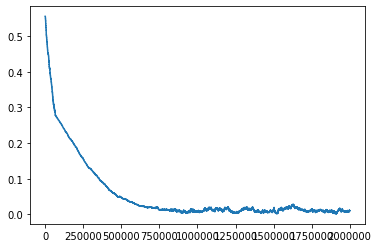

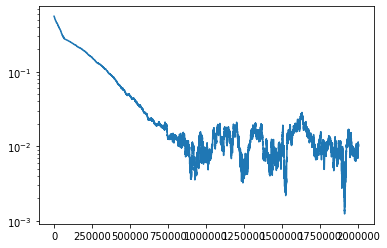

In [6]:
# parameters
gamma = 0.9
alpha = 0.001
max_steps = 2000000
V = np.zeros((env.observation_space.n))

# error plotting
error = np.zeros((max_steps)) # used to track the convergence to Vtrue

x = env.reset()
for t in range(max_steps):
    y,r,d,_ = env.step(fl.RIGHT)
    V[x] = V[x] + alpha * (r+gamma*V[y]-V[x])
    error[t] = np.max(np.abs(V-Vtrue))
    if d==True:
        x = env.reset()
    else:
        x=y

print(V)
print(Vtrue)
plt.plot(error)
plt.figure()
plt.semilogy(error);

<div class="alert alert-warning"><b>Exercice:</b><br>
Can you design a TD(0) algorithm on state-action values functions $Q(s,a)$ that estimates $Q^\pi$ for a given policy $\pi$? Does this algorithm require that the transitions from $s$ to $s'$ be sampled using $\pi$?
</div>

<div class="alert alert-danger"><a href="#TD-Q" data-toggle="collapse"><b>Answers:</b></a><br>
<div id="TD-Q" class="collapse">
We wish to estimate $Q(s,a)$:
$$Q^\pi(s,a) = \mathbb{E}\left( \sum\limits_{t=0}^\infty \gamma^t r\left(s_t, a_t\right) \bigg| s_0 = s, a_0=a, \pi \right) = r(s,a) + \gamma \sum\limits_{s'\in S}p(s'|s,a) Q^\pi(s',\pi(s'))$$

So we can write our temporal difference by bootstrapping with $Q(s',\pi(s'))$. Suppose the last sample was $(s,a,r,s')$.
$$\delta = r + \gamma Q(s',\pi(s')) - Q(s,a)$$
And the update of $Q$ goes as:
$$Q(s,a) \leftarrow Q(s,a) + \alpha \delta$$
As long as all state-action pairs $(s,a)$ are sampled infinitely often as $t\rightarrow\infty$, and under the Robbins-Monro conditions, this procedure should converge to $Q^\pi$. So the transitions should be sampled for every state-action pair and thus do not require to apply $\pi(s)$ in $s$.
</div>
</div>

<div class="alert alert-success"><b>TD(0) temporal difference update on $Q$-functions:</b><br>
For a sample $(s,a,r,s')$, the temporal difference is:
$$\delta = r + \gamma Q(s',\pi(s')) - Q(s,a)$$
And the TD update is:
$$Q(s,a) \leftarrow Q(s,a) + \alpha \left[ r + \gamma Q(s'\pi(s')) - Q(s,a) \right]$$
As long as all state-action pairs $(s,a)$ are sampled infinitely often as $t\rightarrow\infty$, and under the Robbins-Monro conditions, this procedure converges to $Q^\pi$.
</div>

Interestingly, in the exercice above, the samples $(s,a,r,s')$ do not require $a=\pi(s)$. Even better, they actually require to try all possible actions in $s$ for the procedure to converge (not only $\pi(s)$). So this TD(0) algorithm on $Q$-functions is an **off-policy** algorithm. One can obtain the value $Q^\pi$ of a policy $\pi$ without applying $\pi$ for sample collection. This will prove very useful during the class on model-free control.<br>
<br>
<div class="alert alert-warning"><b>Exercice:</b><br>
Let's implement TD(0) on $Q$-functions.<br>
To insure that all states and actions are sampled infinitely often, just act randomly in each state.<br>
In order to speed up convergence, we can initialize $Q(s,a)$ to the value found previously for $V^\pi(s)$.<br>
Use the class on model-based policy evaluation to retrieve the true value of $Q^\pi$ and display convergence of TD(0).
</div>

In [ ]:
# Policy definition and parameters
pi0 = fl.RIGHT*np.ones((env.observation_space.n),dtype=np.int)
gamma = 0.9
alpha = 0.001

# Model based evaluation
def policy_Qeval_iter(pi, epsilon, max_iter):
    Q1 = np.zeros((env.observation_space.n, env.action_space.n))
    Q2 = np.zeros((env.observation_space.n, env.action_space.n))
    residuals = np.zeros((max_iter))
    for i in range(max_iter):
        for x in range(env.observation_space.n):
            for a in range(env.action_space.n):
                Q2[x][a] = 0
                outcomes = env.unwrapped.P[x][a]
                for o in outcomes:
                    p = o[0]
                    y = o[1]
                    r = o[2]
                    Q2[x][a] += p * (r + gamma*Q1[y][pi[y]])
        residuals[i] = np.max(np.abs(Q2-Q1))
        Q1[:] = Q2
        if residuals[i]<epsilon:
            residuals = residuals[:i+1]
            break
    return Q1, residuals

Qtrue, residuals = policy_Qeval_iter(pi0,1e-4,10000)
print("Qtrue:\n", Qtrue)
print("number of iterations:", residuals.size)
plt.plot(residuals)
plt.figure()
plt.semilogy(residuals)

Vtrue = np.zeros((env.observation_space.n))
for x in range(env.observation_space.n):
    Vtrue[x] = Qtrue[x][pi0[x]]
print("Vtrue:\n", Vtrue)

In [ ]:
# TD(0) evaluation of Qpi
# parameters
gamma = 0.9
alpha = 0.001
max_steps=3000000
Q = np.transpose(np.tile(V, (4,1)))

error = np.zeros((max_steps))
x = env.reset()
for t in range(max_steps):
    a = np.random.randint(4)
    y,r,d,_ = env.step(a)
    Q[x][a] = Q[x][a] + alpha * (r+gamma*Q[y][fl.RIGHT]-Q[x][a])
    error[t] = np.max(np.abs(Q-Qtrue))
    if d==True:
        x = env.reset()
    else:
        x=y

print("Max error:", np.max(np.abs(Q-Qtrue)))
plt.plot(error)
plt.figure()
plt.semilogy(error);

## <a id="tdlambda"></a>TD($\lambda$)

With MC and TD(0), we have two methods with different features:
- TD(0): 1-sample update with bootstrapping
- MC: $\infty$-sample update with no bootstrapping

What's inbetween?
- inbetween: $n$-sample update with bootstrapping

We define the **$n$-step target** or **$n$-step return** $R^{(n)}_t$:

$$
\begin{array}{l|l}
R_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \ldots & \textrm{MC}\\
R^{(1)}_t = r_t + \gamma V_t(s_{t+1}) & 1\textrm{-step TD = TD(0)}\\
R^{(2)}_t = r_t + \gamma r_{t+1} + \gamma^2 V_t(s_{t+2}) & 2\textrm{-step TD}\\
R^{(n)}_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \ldots + \gamma^n V_t(s_{t+n}) & n\textrm{-step TD}
\end{array}
$$

And we define the **$n$-step TD update** as:
<div class="alert alert-success"><b>$n$-step TD update:<b>
$$V(s) \leftarrow V(s) + \alpha \left[ R^{(n)}_t - V(s) \right]$$
</div>

So MC corresponds to an $\infty$-step TD update. The $n$-step TD update algorithm converges to the true $V^\pi$ just as TD(0) or MC. It requires to wait for $n$ time steps before performing an update.

Remark: for finite-length  episodes of length $T$, all $n$-step returns for $n>T-t$ are equal to the Monte Carlo return $R_t$.

So $n$-step TD updates bridge a gap between MC and TD(0). But it's not quite satisfying yet because we never really know what value of $n$ is appropriate to speed up convergence for a given problem. An interesting property is that we can mix $n$ and $m$-step returns together. Consider $R^{mix}_t = \frac{1}{3} R^{(2)}_t + \frac{2}{3} R^{(4)}_t$.
Then the update $V(s_t) \leftarrow V(s_t) + \alpha \left[R^{mix}_t - V(s_t)\right]$ still converges to $V^\pi$. More generally, convex sums of $n$-step returns yield update procedures that still converge to $V^\pi$.

Now, take $\lambda\in [0,1]$ and consider the $\lambda$-return $R^\lambda_t$:
<div class="alert alert-success"><b>$\lambda$-return:</b>
$$R^\lambda_t = \left(1-\lambda\right) \sum\limits_{n=1}^\infty \lambda^{n-1}R_t^{(n)}$$
</div>

The $\lambda$-return is the mixing of *all* $n$-step returns, with weights $(1-\lambda) \lambda^{n-1}$. So, an agent performing a $\lambda$-return update looks one step in the future and uses that step to update $V(s)$ with weight $(1-\lambda)$, then looks 2 steps into the future and updates $V(s)$ with a weight $\lambda (1-\lambda)$ and so on. The illustrative figure below is an excerpt from **Reinforcement Learning: an introduction** by Sutton and Barto.

<img src="images/TD_lambda_forward.png"></img>

To get a better understanding of the $\lambda$-return and to set ideas, let us consider a finite length episode $(s_t, r_t, s_{t+1}, \ldots, s_T)$. Since the episode ends after $T$, we have $\forall k>0, \ R^{(T-t+k)}_t = R_t$. Thus, we can split the $\lambda$-return sum in two:

\begin{align*}
R^\lambda_t & = \left(1-\lambda\right) \sum\limits_{n=1}^{T-t-1} \lambda^{n-1}R_t^{(n)} + \left(1-\lambda\right) \sum\limits_{n=T-t}^{\infty} \lambda^{n-1}R_t^{(n)}\\
& = \left(1-\lambda\right) \sum\limits_{n=1}^{T-t-1} \lambda^{n-1}R_t^{(n)} + \left(1-\lambda\right) \lambda^{T-t-1} \sum\limits_{n=T-t}^{\infty} \lambda^{n-T+t} R_t^{(n)}\\
& = \left(1-\lambda\right) \sum\limits_{n=1}^{T-t-1} \lambda^{n-1}R_t^{(n)} + \left(1-\lambda\right) \lambda^{T-t-1} \sum\limits_{k=0}^{\infty} \lambda^{k} R_t^{(T-t+k)}\\
& = \left(1-\lambda\right) \sum\limits_{n=1}^{T-t-1} \lambda^{n-1}R_t^{(n)} + \lambda^{T-t-1} R_t\\
\end{align*}

So we have $R^\lambda_t = \left(1-\lambda\right) \sum\limits_{n=1}^{T-t-1} \lambda^{n-1}R_t^{(n)} + \lambda^{T-t-1} R_t$.
- When $\lambda = 0$, it is a $TD(0)$ update (hence the "0" in TD(0)).
- When $\lambda = 1$, it is a MC update.
So we can define the **$\lambda$-return algorithm** that generalizes on TD(0) and MC:
<div class="alert alert-success"><b>$\lambda$-return algorithm:</b>
$$V(s_t) \leftarrow V(s_t) + \alpha \left[R^{\lambda}_t - V(s_t)\right] $$
</div>

That's all very nice and we have replaced the choice of $n$ by the choice of $\lambda$ that seems less sensitive. But, still, we don't know how to compute those $n$-step returns, and the $\lambda$-return, without running $n$-step episodes (and thus infinite episodes for the $\lambda$-return in the general case).

This is where we need to flip the little man in the drawing above to make him look backwards in time. When an agent transitions from $s$ to $s'$ and obtains reward $r$, it can compute the $1$-step return for $s$ and perform the corresponding $1$-step TD update. Then, as it transitions from $s'$ to $s''$ and observes $r'$ it can perform the $1$-step TD update in $s'$, but also the $2$-step TD update in $s$! An so on for future transitions. So, incrementally, as time unrolls, the agent will include the $n$-step updates in the $\lambda$-return of $s$ as they become available. In the limit, when $t\rightarrow\infty$, the $\lambda$-return in every state will be complete and the agent will have completed a $\lambda$-return algorithm. This figure below (excerpt from **Reinforcement Learning: an introduction** by Sutton and Barto) illustrates this *backward-view* on TD updates.

<img src="images/TD_lambda_backward.png"></img>

This seems to imply that we need to remember the states we went through, which is quite the same as remembering full episodes for MC updates. But since we want to update a state seen $n$ steps ago with a weight $\lambda^n (1-\lambda)$, we just need to remember, for each state, the last time we visited it (and we can forget about the trajectory linking states together). This way, we store $|S|$ values at all time, instead of an increasingly long sequence of transitions. In order to do this, we introduce the notion of **eligibility trace**:
<div class="alert alert-success"><b>Eligibility trace of state $s$:</b>
$$e_t(s) = \left\{\begin{array}{ll}
\gamma \lambda e_{t-1}(s) & \textrm{if }s\neq s_t\\
1 & \textrm{if }s = s_t
\end{array}\right.$$
</div>
Initially, all states have an eligibility trace of zero. The eligibility trace of an unvisited state decays exponentially. So $e_t(s)$ measures how old the last visit of $s$ is.<br>
<br>
Note that two alternative definitions of eligibility traces prevail:
<ul>
    <li> "<b>replacing traces</b>": $e_t(s) = 1\textrm{ if }s = s_t$
    <li> "<b>accumulating traces</b>": $e_t(s) = e_{t-1}(s) + 1\textrm{ if }s = s_t$
</ul>
Often (not always), replacing traces are used in practice.<br>
<br>
And finally we can define the TD($\lambda$) algorithm:
<div class="alert alert-success"><b>TD($\lambda$) algorithm:</b><br>
Given a new sample $(s_t,a_t,r_t,s_t')$.
<ol>
<li> Temporal difference $\delta = r_t+\gamma V(s_t') - V(s_t)$.
<li> Update eligibility traces for all states<br>
$e(s) \leftarrow \left\{\begin{array}{ll}
\gamma \lambda e(s) & \textrm{if } s\neq s_t\\
1 & \textrm{if } s=s_t
\end{array}\right.$
<li> Update all state's values $V(s) \leftarrow V(s) + \alpha e(s) \delta$
</ol>
Initially, $e(s)=0$.
</div>

Properties and remarks:
- Earlier states are given $e(s)$ *credit* for the TD error $\delta$
- If $\lambda=0$, $e(s)=0$ except in $s_t$ $\Rightarrow$ standard TD(0)
- For $0<\lambda<1$, $e(s)$ indicates a distance $s \leftrightarrow s_t$ is in the episode.
- If $\lambda=1$, $e(s)=\gamma^\tau$ where $\tau=$ duration since last visit to $s_t$ $\Rightarrow$ MC method<br>
TD(1) implements Monte Carlo estimation on non-episodic problems!<br>
TD(1) learns incrementally for the same result as MC
- **TD($\lambda$) is equivalent to the $\lambda$-return algorithm.**
- The value of $\lambda$ can even be changed during the algorithm without impacting convergence.

<div class="alert alert-warning"><b>Exercice:</b><br>
Implement a TD($\lambda$) algorithm to estimate $V^\pi$. As before, take a constant $\alpha=0.001$ and $\lambda=0.5$.
</div>

In [ ]:
# parameters
gamma = 0.9
lambd = 0.5
alpha = 0.001
max_steps = 2000000
V = np.zeros((env.observation_space.n))
e = np.zeros((env.observation_space.n))

# error plotting
error = np.zeros((max_steps)) # used to track the convergence to Vtrue

x = env.reset()
for t in range(max_steps):
    y,r,d,_ = env.step(fl.RIGHT)
    delta = r+gamma*V[y]-V[x]
    for s in range(env.observation_space.n):
        if s==x:
            e[s] = 1
        else:
            e[s] = e[s]*gamma*lambd
        V[s] = V[s] + alpha * e[s] * delta
    error[t] = np.max(np.abs(V-Vtrue))
    if d==True:
        x = env.reset()
    else:
        x=y

print(V)
print(Vtrue)
plt.plot(error)
plt.figure()
plt.semilogy(error);

## <a id="predsummary"></a>Summary

- Prediction = evaluation of a given behaviour
- Model-based prediction
- Monte Carlo (offline and online)
- Temporal Differences, TD(0)
- Unifying MC and TD: TD($\lambda$)

# <a id="approx"></a>Value Function approximation

If this is the first time you read this notebook, this part can be skipped (but please come back later, it's still quite important).

Often, $S$ is not finite (or is just too large to be enumerated). Consequently, $\mathcal{F}(S,\mathbb{R})$ has infinite (or just too large) dimension. Thus, tabular representations of $V$ are not possible and one needs to turn to the function representation $V_\theta$ with parameters $\theta$. In this section, we work our way through approximation methods for $V$.

The FrozenLake example is a toy problem with very few states (moreover discrete). It does not lend itself to a convincing demonstration of value function approximation. We shall remain at the theoretical level for the following considerations and reserve practice for later.

## <a id="linear"></a>Linear value function approximation

Suppose we write $V$ as a linear model:
$$V(s) = \theta^T \varphi(s) = \sum_{i=1}^K \theta_i \varphi_i(s)$$

We wish to approximate $V(s)$ as a linear combination of features $\varphi(s)=\left(\varphi_i(s)\right)_{i\in[1,K]}$. This way, $V$ lives in the $K$-dimensional function space $span(\varphi)$. We have plenty of families of functions that we can rely on and the user's expertise plays a big role in choosing a proper **functional basis**. Generally speaking, we would expect the following properties from a good basis:
- the target $V^\pi$ can be closely approximated by its projection on $\varphi$
- given an initial $V_0 \in span(\varphi)$ and the recurrence relation $V_{n+1} = \Pi_\varphi (T^\pi V_n)$ (where $\Pi_\varphi$ is the projection operator on $span(\varphi)$), $V_n$ should be a "close enough" approximation of $T^\pi V_n$. This property is illustrated by the figure below (for $Q$ instead of $V$ - excerpt from Lagoudakis and Parr, 03).
- $\varphi$ should form a basis (that is $\varphi_i \bot \varphi_j$)

<img src="images/projection.png" style="width: 600px;"></img>

If $\sum_{i=1}^K \varphi_i(s) = 1$, then $V_\theta$ is called an *averager*. Averagers are known to be well-behaved for iterative function approximation. Otherwise, other non-averager, families of functions are commonly used:

- $\cos$, $\sin$ over state variables (mimics the Fourier transform, extends to wavelet bases)
- polynomials of the state variables (mimics the Taylor expansion)
- radial basis functions of the state variables (performs local approximation, extends to kernel smoothing).
- among averagers, piecewise constant local functions $\varphi_i(s) \in \{0;1\}$ group *neighborhoods* in the state space together (note the similarity with tree-based regressors).

A very straightforward way of building feature sets is to define features depending on a single state variable and then using the tensor product in order to obtain all possible combinations of sigle-variable features. More formally and more generally, suppose $S \subset S_1\times \ldots \times S_k$ and suppose $\varphi^{(i)}$ defines $d_i$ features over $S_k$; then the tensor product $\varphi^{(1)} \otimes \ldots \otimes \varphi^{(k)}$ yields $d=d_1\ldots d_k$ feature functions on $S$. But there is a catch, the number of these resulting features grows exponentially with $k$ and so does the dimension of the value function's search space $span(\varphi)$: that is the **curse of dimensionality** that makes searching for a value function exponentially more difficult as the state space dimension grows.

Additionnaly, there is **no guarantee** that, for a given $V_n \in span(\varphi)$, $T^\pi V_n$ actually lives in $span(\varphi)$.

But on the bright side, given an initial state $s_0$, the actual reachable space $S'$ given $\pi$ might be much smaller than $S$. So, in practice, we just need to obtain a good approximation of $V$ on the subspace $S'$ (a manifold of $S$).

Anyway, to conclude this short paragraph on feature engineering:
- good feature engineering in RL is even more crucial than in supervized learning.
- it can be very problem-dependent.
- good function approximators (generally non-parametric to avoid the fixed $span(\varphi)$) are of crucial importance.
We will discuss non-linear and non-parametric function approximation a bit further in the notebook.

## <a id="tab"></a>The tabular case is just a specific case of linear model

In the discrete state space case, consider the averager defined as:
$$\varphi_i(s) = \left\{\begin{array}{ll}1 & \textrm{if }s=s_i\\ 0 & \textrm{otherwise}\end{array}\right.$$
Feature function $\varphi_i$ is the indicator function of state $s_i$. Therefore, we have $|S|$ feature functions. So when we write $V(s) = \sum_{i=1}^{|S|} \theta_i \varphi_i(s)$, we actually have $V(s_i) = \theta_i$. Therefore the tabular representation of $V$ is equivalent to a linear model with the $\varphi_i$ feature functions.

Based on the previous remark, let us rewrite TD($\lambda$) as a linear model update (we take the accumulating traces version; the replacing traces case is equivalent). We had previously:<br>
Given a new sample $(s_t,a_t,r_t,s_t')$.
<ol>
<li> Temporal difference $\delta = r_t+\gamma V(s_t') - V(s_t)$.
<li> Update eligibility traces for all states<br>
$e(s) \leftarrow \left\{\begin{array}{ll}
\gamma \lambda e(s) & \textrm{if } s\neq s_t\\
1 + \gamma \lambda e(s)& \textrm{if } s=s_t
\end{array}\right.$
<li> Update all state's values $V(s) \leftarrow V(s) + \alpha e(s) \delta$
</ol>
Initially, $e(s)=0$.

The temporal difference can be rewritten $\delta = r_t+\gamma\theta^T \varphi(s_t') - \theta^T \varphi(s_t)$.

The eligibility trace update can be rewritten $e \leftarrow \varphi(s) + \gamma \lambda e$.

Similarly the value update can be rewritten $\theta \leftarrow \theta + \alpha e \delta$.

## <a id="param"></a>TD($\lambda$) as a parametric model update

We generalize the previous result to the general linear model case:
<div class="alert alert-success"><b>TD($\lambda$) with linear model approximation:</b><br>
With $V(s) = \sum_{i=1}^K \theta_i \varphi_i(s)$, $e \in \mathbb{R}^K$.<br>
Initially, $e=0$.<br>
Given a new sample $(s_t,a_t,r_t,s_t')$.
<ol>
<li> Temporal difference $\delta = r_t+\gamma\theta^T \varphi(s_t') - \theta^T \varphi(s_t)$.
<li> Update eligibility traces for all states $e \leftarrow \varphi(s) + \gamma \lambda e$
<li> Update value function $\theta \leftarrow \theta + \alpha e \delta$
</ol>
</div>

And finally, we can further generalize the TD($\lambda$) update above to the general case of a parametric (not necessarily linear) function approximation $V_\theta$:
<div class="alert alert-success"><b>TD($\lambda$) with parametric function approximation:</b><br>
With $V(s) = V_\theta(s), \theta \in \mathbb{R}^K$, $e \in \mathbb{R}^K$.<br>
Initially, $e=0$.<br>
Given a new sample $(s_t,a_t,r_t,s_t')$.
<ol>
<li> Temporal difference $\delta = r_t+\gamma V_\theta(s_t') - V_\theta(s_t)$.
<li> Update eligibility traces for all states $e \leftarrow \nabla_\theta V_\theta(s) + \gamma \lambda e$
<li> Update value function $\theta \leftarrow \theta + \alpha e \delta$
</ol>
</div>

Note that we have provided the results above without proof. We will admit them and refer the reader to RL textbooks for a rigorous justification.

## <a id="nonparam"></a>Non-parametric models

Non-parametric models generally refer to function approximators that do not rely on an a-priori fixed finite-dimensional search space and allows the representation space to evolve as needed. Among those non-parametrics models, one can count:
- linear approximations that incrementally enrich the functional basis.
- general supervised learning methods: SVMs, k-nearest neighbours (kernel smoothing methods), Gaussian Processes, tree-based methods, neural networks, etc.

One quickly realizes that the frontier between parametric and non-parametric models is blur. The TD($\lambda$) update above actually holds for most methods for which a finite dimensional parameter vector $\theta$ exists (even though the function search space changes). In the general case of a $s \mapsto V(s)$ function approximator, the general idea is to feed this approximator with samples of the form $(s, r+\gamma V(s'))$.

To conclude this overview of value function approximation issues. We make the following remarks:
- TD($\lambda$) is an on-policy method.<br>
Indeed, it evaluates the policy currently applied. But one could wonder: could I apply some policy and still evaluate another one. It appears this question is non-trivial and a direct extension of TD($\lambda$) to the off-policy case is actually non-convergent. This was solved after 2009 by the family of **Gradient temporal difference learning** algorithms.
- TD methods solve the $V = T^\pi V$ equation.<br>
Then, one could see those methods as algorithms that incrementally minimize $\|V-T^\pi V\|^2$, that is, least squares minimizers. This leads to the (vast) family of **Least Squares methods** that often provide good stability and accuracy properties at the cost of increased computational requirements.